In [1]:
import time
import random
import numpy as np
import pandas as pd

from scipy import signal
from source.NN_environment import normalise_series
from sklearn.preprocessing import normalize

from source.Files_operating import read_sht_data
from source.Peaks_processing import *

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib.colors import CSS4_COLORS as COLORS

colors = ['gold', 'brown', 'black', 'seagreen', 'skyblue', 'cyan', 'yellow', 'violet', 'royalblue', 'sandybrown', 'grey', 'gray', 'indigo', 'rosybrown', 'darkviolet', 'coral', 'pink', 'magenta', 'red', 'springgreen', 'darkblue', 'silver', 'seashell', 'green', 'navy', 'purple', 'sienna', 'chocolate', 'orange', 'blue']

shtRipper v1.3


In [2]:
def filt_signal(arr, N, W):
    b, a = signal.butter(N, W)
    return signal.filtfilt(b, a, arr)

def smooth_rect(y, box_pts):
    box = np.ones(box_pts) / box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def smooth_gauss(y, box_pts, sigma=1):
    x = np.arange(box_pts) - box_pts / 2
    box = 1 / sigma / (2 * np.pi) ** 0.5 * np.exp(-x ** 2 / 2 / sigma ** 2)
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def smooth_steklov(y, box_pts, ro=0.1):    
    c = 1 / 0.4439938161681
    x_ro = (np.arange(box_pts) - box_pts / 2) / (box_pts / 2 * ro)
    box = np.zeros(box_pts)
    box[abs(x_ro) < 1] = 1 / (box_pts / 2 * ro) * c * np.exp(1 / (x_ro[abs(x_ro) < 1] ** 2 - 1))
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [5]:
F_ID = 44170
proj_path = "C:/Users/f.belous/Work/Projects/Plasma_analysis"
# D:/Edu/Lab/Projects/Plasma_analysis | C:/Users/f.belous/Work/Projects/Plasma_analysis
sht_dir_path = proj_path + "/data/sht/all/"  
mhd_dir_path = proj_path + "/data/mhd/"

df = read_sht_data(f'sht{F_ID}', sht_dir_path)
df = df.rename(columns={"ch1": "d_alpha"})
df["sxr"] = read_sht_data(f'sht{F_ID}', sht_dir_path, data_name="SXR 50 mkm").ch1
df["nl"] = read_sht_data(f'sht{F_ID}', sht_dir_path, data_name="nl 42 cm (1.5мм) 64pi").ch1
df["mhd4"] = read_sht_data(f'mhd{F_ID}', mhd_dir_path, data_name="МГД4").ch1

# mgd_data_vertical
df["mgd_v"] = read_sht_data(f'sht{F_ID}', sht_dir_path, data_name="МГД быстрый зонд верт.").ch1
# mgd_data_radial
df["mgd_r"] = read_sht_data(f'sht{F_ID}', sht_dir_path, data_name="МГД быстрый зонд рад.").ch1

df.describe()

,t,d_alpha,sxr,nl,mhd4
count,393216.000000,393216.000000,393216.000000,393216.000000,393216.000000
mean,0.196608,0.288921,0.408335,28.962140,-0.008929
std,0.113512,0.421453,0.670086,13.324546,0.175156
min,0.000000,-0.408984,-0.076685,-6.702231,-2.600000
25%,0.098304,0.015337,0.097134,15.897223,-0.059668
50%,0.196607,0.066460,0.099690,36.003917,-0.002539
75%,0.294911,0.570022,0.322075,36.685898,0.044434
max,0.393215,4.887363,4.268774,48.138483,2.598730


In [6]:
d_alpha = df.d_alpha.to_numpy()
sxr = df.sxr.to_numpy()
mhd = df.mgd_v.to_numpy() ** 2 + df.mgd_r.to_numpy() ** 2

d_alpha_d1 = np.diff(d_alpha)
sxr_d1 = np.diff(sxr)

d_alpha_f = filt_signal(d_alpha_d1, 5, 0.1)
sxr_f = filt_signal(sxr_d1, 5, 0.05)

In [7]:
dbs_dir_path = proj_path + "/data/dbs/sht/"
dbs_df = read_sht_data(f'Dref{F_ID}', dbs_dir_path, data_name="ch1")
channels = [1, 2, 3, 4]
for i in channels[1:]:
    dbs_df[f"ch{i}"] = read_sht_data(f'Dref{F_ID}', dbs_dir_path, data_name=f"ch{i}").ch1

dbs_df.describe()

,t,ch1,ch2,ch3,ch4
count,512000.000000,512000.000000,512000.000000,512000.000000,512000.000000
mean,0.164000,0.056485,0.149372,0.155116,0.135516
std,0.036951,0.310325,0.698598,0.192810,0.193228
min,0.100000,-1.660156,-4.000000,-1.304688,-1.458984
25%,0.132000,-0.070312,-0.152344,0.066406,0.048828
50%,0.164000,0.058594,0.150391,0.156250,0.134766
75%,0.196000,0.185547,0.435547,0.244141,0.226563
max,0.228000,2.562500,3.998047,1.830078,1.548828


In [8]:
for ind in range(1, len(channels) + 1, 2):
    w = 0.8
    smooth_lenght = 500
    i_data = dbs_df[f"ch{ind}"].to_numpy() # normalise_series() filt_signal( , 5, w)  smooth_steklov( , smooth_lenght, smooth_lenght / 2)
    i_data /= np.linalg.norm(i_data)
    q_data = dbs_df[f"ch{ind + 1}"].to_numpy()
    q_data /= np.linalg.norm(q_data)

    c_data = filt_signal(i_data, 5, w) + filt_signal(q_data, 5, w)*1j

    fi_data = np.angle(c_data)
    # coef = 1
    # for i in range(1, fi_data.shape[0]):
    #     if q_data[i] * q_data[i - 1] <= 0:
    #         coef *= -1
    #     fi_data[i] *= coef

    dbs_df[f"ch{ind}_A"] = smooth_steklov(np.abs(c_data), smooth_lenght, 0.85)
    dbs_df[f"ch{ind}_dfi"] = smooth_steklov(np.concatenate([np.abs(np.diff(fi_data)), [0]]), smooth_lenght, 0.5)  # np.concatenate([np.diff(), [0]]) smooth_gauss(np.concatenate([filt_signal(np.diff(np.angle(c_data)), 5, w), [0]]), 300)

dbs_df.describe()

,t,ch1,ch2,ch3,ch4,ch1_A,ch1_dfi,ch3_A,ch3_dfi
count,512000.000000,512000.000000,512000.000000,512000.000000,512000.000000,512000.000000,512000.000000,512000.000000,512000.000000
mean,0.164000,0.000250,0.000292,0.000876,0.000802,0.001509,0.388497,0.001710,0.278920
std,0.036951,0.001375,0.001367,0.001089,0.001144,0.000803,0.272753,0.000411,0.204534
min,0.100000,-0.007356,-0.007825,-0.007368,-0.008639,0.000191,0.009061,0.000572,0.022793
25%,0.132000,-0.000312,-0.000298,0.000375,0.000289,0.000817,0.132738,0.001376,0.081429
50%,0.164000,0.000260,0.000294,0.000882,0.000798,0.001503,0.382167,0.001705,0.253215
75%,0.196000,0.000822,0.000852,0.001379,0.001342,0.001978,0.594425,0.002007,0.412428
max,0.228000,0.011354,0.007821,0.010335,0.009171,0.004719,1.404564,0.003150,1.171455


---
---

In [43]:
df_groups_arr = []  # l_edge, r_edge, n, fr, fr_std
df_points_arr = []

In [16]:
meta_sxr = Signal_meta(chanel_name="sxr", processing_flag=True)
meta_sxr.set_statistics(sxr, sxr_f, 0.8, 0.8, d_std_bottom_edge=7., d_std_top_edge=13.0)
meta_sxr.set_edges(length_edge=5, distance_edge=30, scale=0, step_out=20)

In [17]:
mark_data = np.zeros(sxr_f.shape)
mark_data[abs(sxr_f - meta_sxr.d_q) > meta_sxr.d_std * meta_sxr.d_std_bottom] = 1
mark_sxr = proc_slices(mark_data, sxr, sxr_f, meta_sxr)

In [18]:
# get slices from standart sxr proccessing
sxr_slices = get_slices(mark_sxr)  # [Slice(0, 0)] + 
slices_edges = []
step_out = 50

len_top = 5000
len_width = 3000
len_step = 2000

# get slices btw sxr falls
slices_edges.append([sxr_slices[0].r + step_out, 0])
for i in range(1, len(sxr_slices)):
    cur_l_edge = slices_edges[-1][0]
    while sxr_slices[i].l - step_out - cur_l_edge > len_top:
        slices_edges[-1][1] = cur_l_edge + len_width
        slices_edges.append([cur_l_edge + len_width, 0])
        cur_l_edge += len_step
    
    slices_edges[-1][1] = sxr_slices[i].l - step_out
    slices_edges.append([sxr_slices[i].r + step_out, 0])

slices_edges[-1][1] = min(sxr_slices[-1].r + 1000, sxr.shape[0] - step_out)
slices_edges = np.array(slices_edges)
print(len(slices_edges))

20


In [19]:
# proccess Slice(0, 1st sxr fall)
first_slice = Slice(150, sxr_slices[0].l + step_out)
print(first_slice)

d_alpha_slice = d_alpha[first_slice.l: first_slice.r]
d_alpha_f_slice = d_alpha_f[first_slice.l: first_slice.r]

meta_da = Signal_meta(chanel_name="da", processing_flag=True)
meta_da.set_statistics(d_alpha, d_alpha_f, 0.7, 0.7, d_std_bottom_edge=2., d_std_top_edge=1.0)
meta_da.set_edges(length_edge=50, distance_edge=100)

mark_data = np.zeros(d_alpha_f_slice.shape)
mark_data[abs(d_alpha_f_slice - meta_da.d_q) > meta_da.d_std * meta_da.d_std_bottom] = 1
# mark_d_alpha = proc_slices(mark_data, d_alpha_slice, d_alpha_f_slice, meta_da)

da_slices = get_slices(mark_data)  # list(filter(lambda x: x.check_length(10), get_slices(mark_d_alpha)))

first_slice_edges = []
dist_top = 1000
step_out = 100

first_slice_edges.append([max(0, da_slices[0].l - step_out), da_slices[0].r + step_out])
for i in range(len(da_slices)):
    if da_slices[i].l - first_slice_edges[-1][1] > dist_top:
        first_slice_edges.append([da_slices[i].l - step_out, da_slices[i].l])
    elif first_slice_edges[-1][1] - first_slice_edges[-1][0] > len_top:
        first_slice_edges.append([first_slice_edges[-1][1] - step_out, first_slice_edges[-1][1]])
    first_slice_edges[-1][1] = da_slices[i].r + step_out
        

first_slice_edges = np.array(first_slice_edges) + 150
print(len(first_slice_edges))

(150, 185351)
15


In [20]:
res_slices_edges = np.concatenate([first_slice_edges, slices_edges]).astype(np.int64)  # slices_edges.astype(np.int64)

print(len(res_slices_edges))

35


---
---


------
------

25/35 - Slice (216.688, 220.187) ms - mark: 0.0 (1 - dELM, 2 - LCO, 3 - EHO) - 17 peaks - 6.984 ms
Start prossecing peaks ... - Tooks: 12.960 ms
1/6 Group of peaks [0-1] (gold) - 2 peaks in group - mean delta: 0.148 ms - freq: 6.757 +- 0.000 kHz
2/6 Group of peaks [1-4] (brown) - 4 peaks in group - mean delta: 0.087 ms - freq: 11.538 +- 0.586 kHz
3/6 Group of peaks [6-12] (black) - 3 peaks in group - mean delta: 0.615 ms - freq: 1.627 +- 0.099 kHz
4/6 Group of peaks [12-14] (seagreen) - 3 peaks in group - mean delta: 0.141 ms - freq: 7.092 +- 1.655 kHz
5/6 Group of peaks [14-16] (skyblue) - 2 peaks in group - mean delta: 0.695 ms - freq: 1.439 +- 0.000 kHz
6/6 Group of peaks [15-16] (cyan) - 2 peaks in group - mean delta: 0.178 ms - freq: 5.618 +- 0.000 kHz


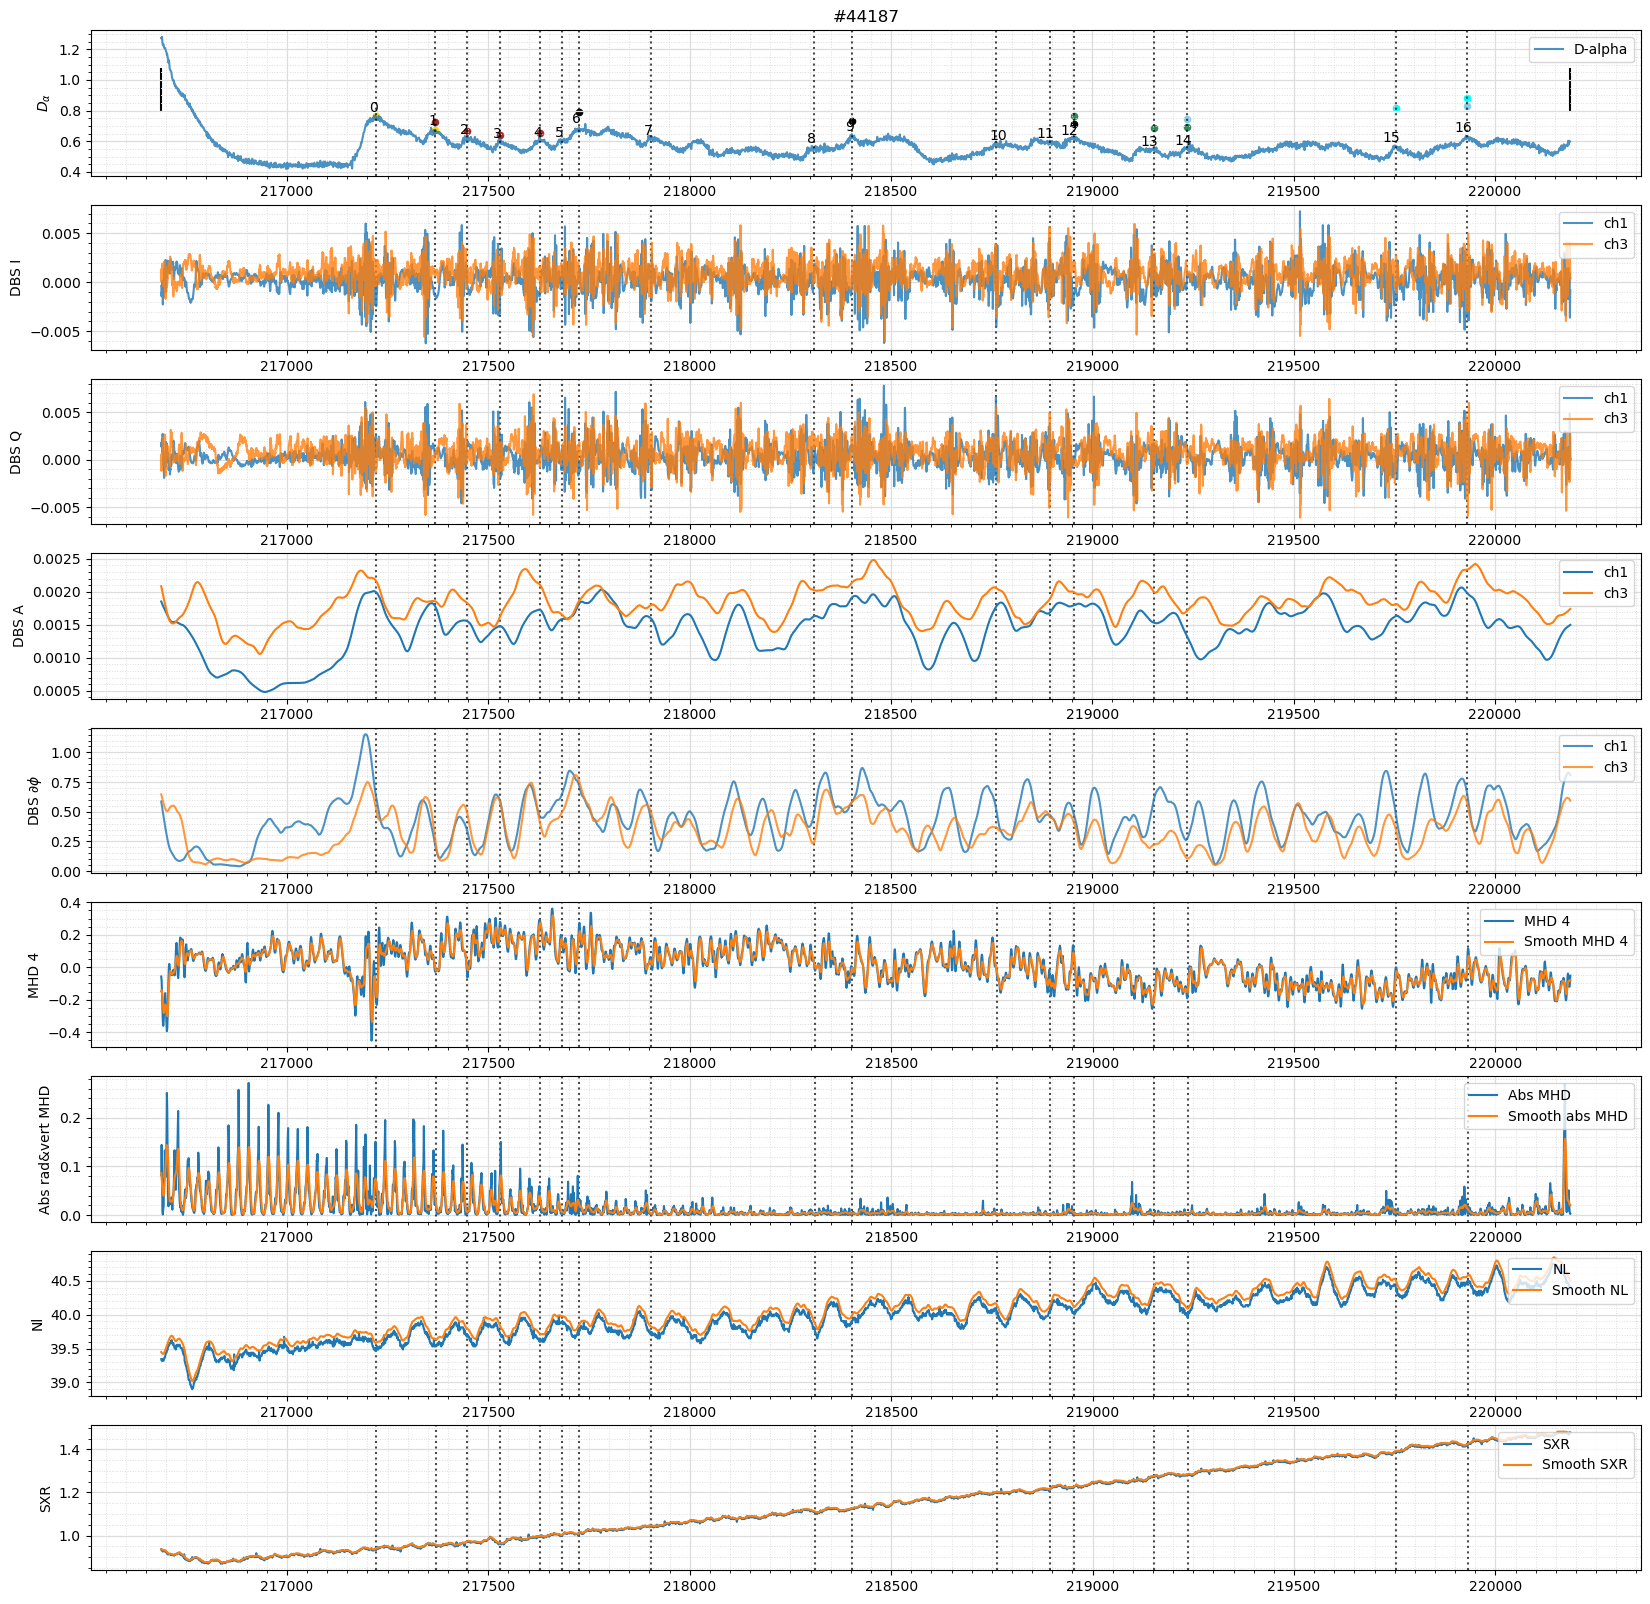

Input mode [manual (input points) - 0 | auto (input group) - 1 | continue - -1]:  1
Input group number (from 1 to 6):  2
Input mark of the group (string: eho|lco|delm) ejo


Group stats: n: 4, fr: (11.538 +- 0.586) kHZ
------


Input mode [manual (input points) - 0 | auto (input group) - 1 | continue - -1]:  



------
------

26/35 - Slice (220.379, 224.686) ms - mark: 0.0 (1 - dELM, 2 - LCO, 3 - EHO) - 20 peaks - 8.975 ms
Start prossecing peaks ... - Tooks: 17.024 ms
1/7 Group of peaks [0-3] (gold) - 2 peaks in group - mean delta: 0.425 ms - freq: 2.353 +- 0.000 kHz
2/7 Group of peaks [3-10] (brown) - 5 peaks in group - mean delta: 0.254 ms - freq: 3.945 +- 0.925 kHz
3/7 Group of peaks [6-14] (black) - 5 peaks in group - mean delta: 0.369 ms - freq: 2.710 +- 0.602 kHz
4/7 Group of peaks [13-17] (seagreen) - 4 peaks in group - mean delta: 0.457 ms - freq: 2.188 +- 0.368 kHz
5/7 Group of peaks [15-16] (skyblue) - 2 peaks in group - mean delta: 0.205 ms - freq: 4.878 +- 0.000 kHz
6/7 Group of peaks [16-19] (cyan) - 4 peaks in group - mean delta: 0.365 ms - freq: 2.740 +- 0.740 kHz
7/7 Group of peaks [17-19] (yellow) - 3 peaks in group - mean delta: 0.279 ms - freq: 3.584 +- 1.409 kHz


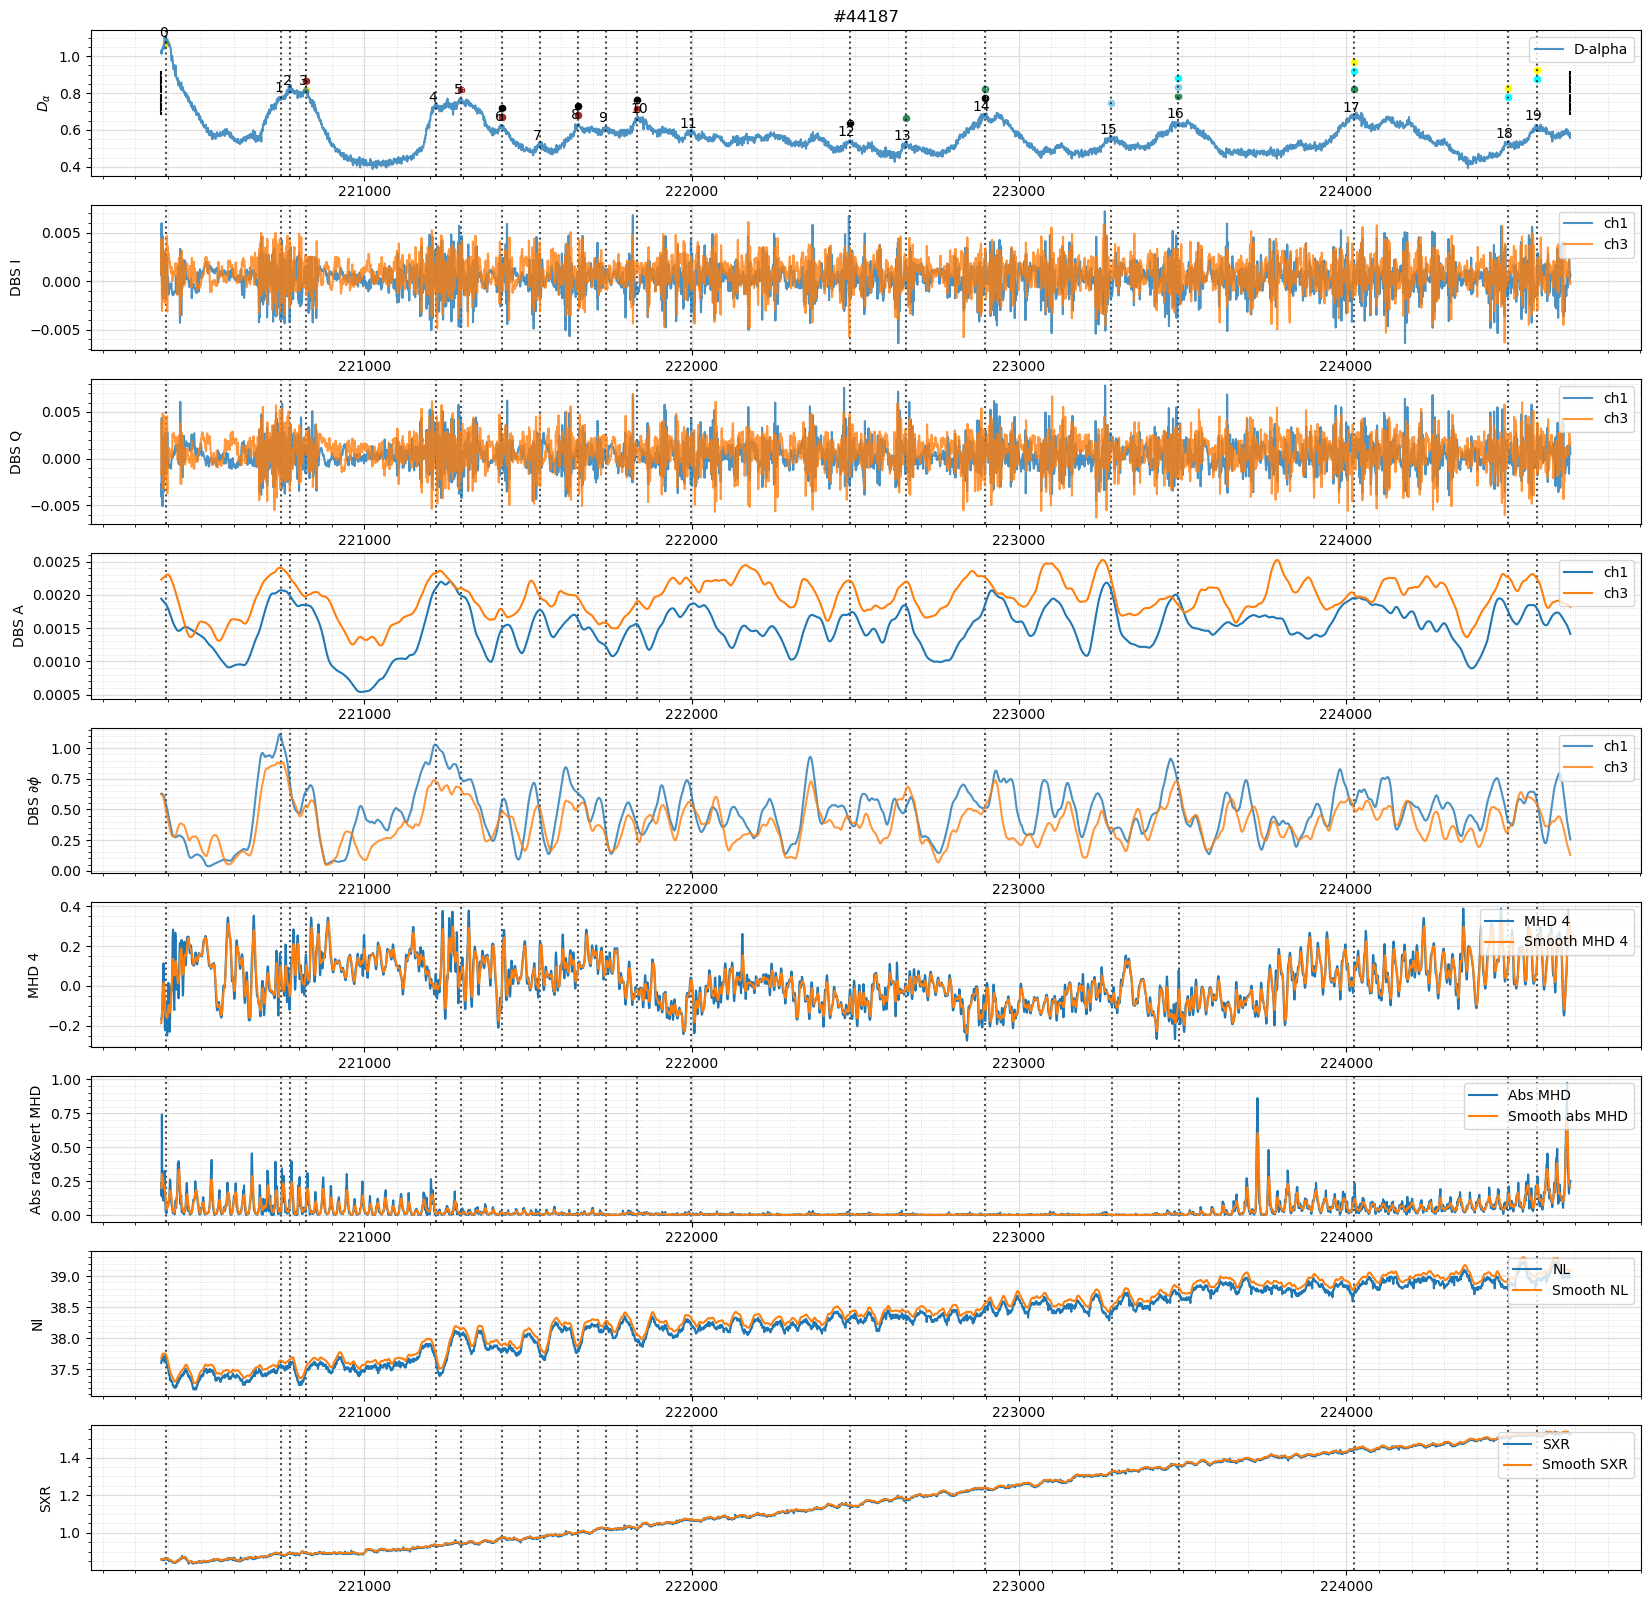

Input mode [manual (input points) - 0 | auto (input group) - 1 | continue - -1]:  0
Input point indexes:
 2 5
Input mark of the group (string: eho|lco|delm) delm


Group stats: n: 2, fr: (1.919 +- 0.000) kHZ
------


Input mode [manual (input points) - 0 | auto (input group) - 1 | continue - -1]:  



------
------

27/35 - Slice (224.873, 228.228) ms - mark: 0.0 (1 - dELM, 2 - LCO, 3 - EHO) - 16 peaks - 6.982 ms
Start prossecing peaks ... - Tooks: 11.968 ms
1/5 Group of peaks [1-4] (gold) - 3 peaks in group - mean delta: 0.365 ms - freq: 2.736 +- 0.516 kHz
2/5 Group of peaks [5-9] (brown) - 3 peaks in group - mean delta: 0.282 ms - freq: 3.546 +- 0.174 kHz
3/5 Group of peaks [9-10] (black) - 2 peaks in group - mean delta: 0.398 ms - freq: 2.513 +- 0.000 kHz
4/5 Group of peaks [11-15] (seagreen) - 3 peaks in group - mean delta: 0.499 ms - freq: 2.002 +- 0.216 kHz
5/5 Group of peaks [14-15] (skyblue) - 2 peaks in group - mean delta: 0.050 ms - freq: 20.000 +- 0.000 kHz


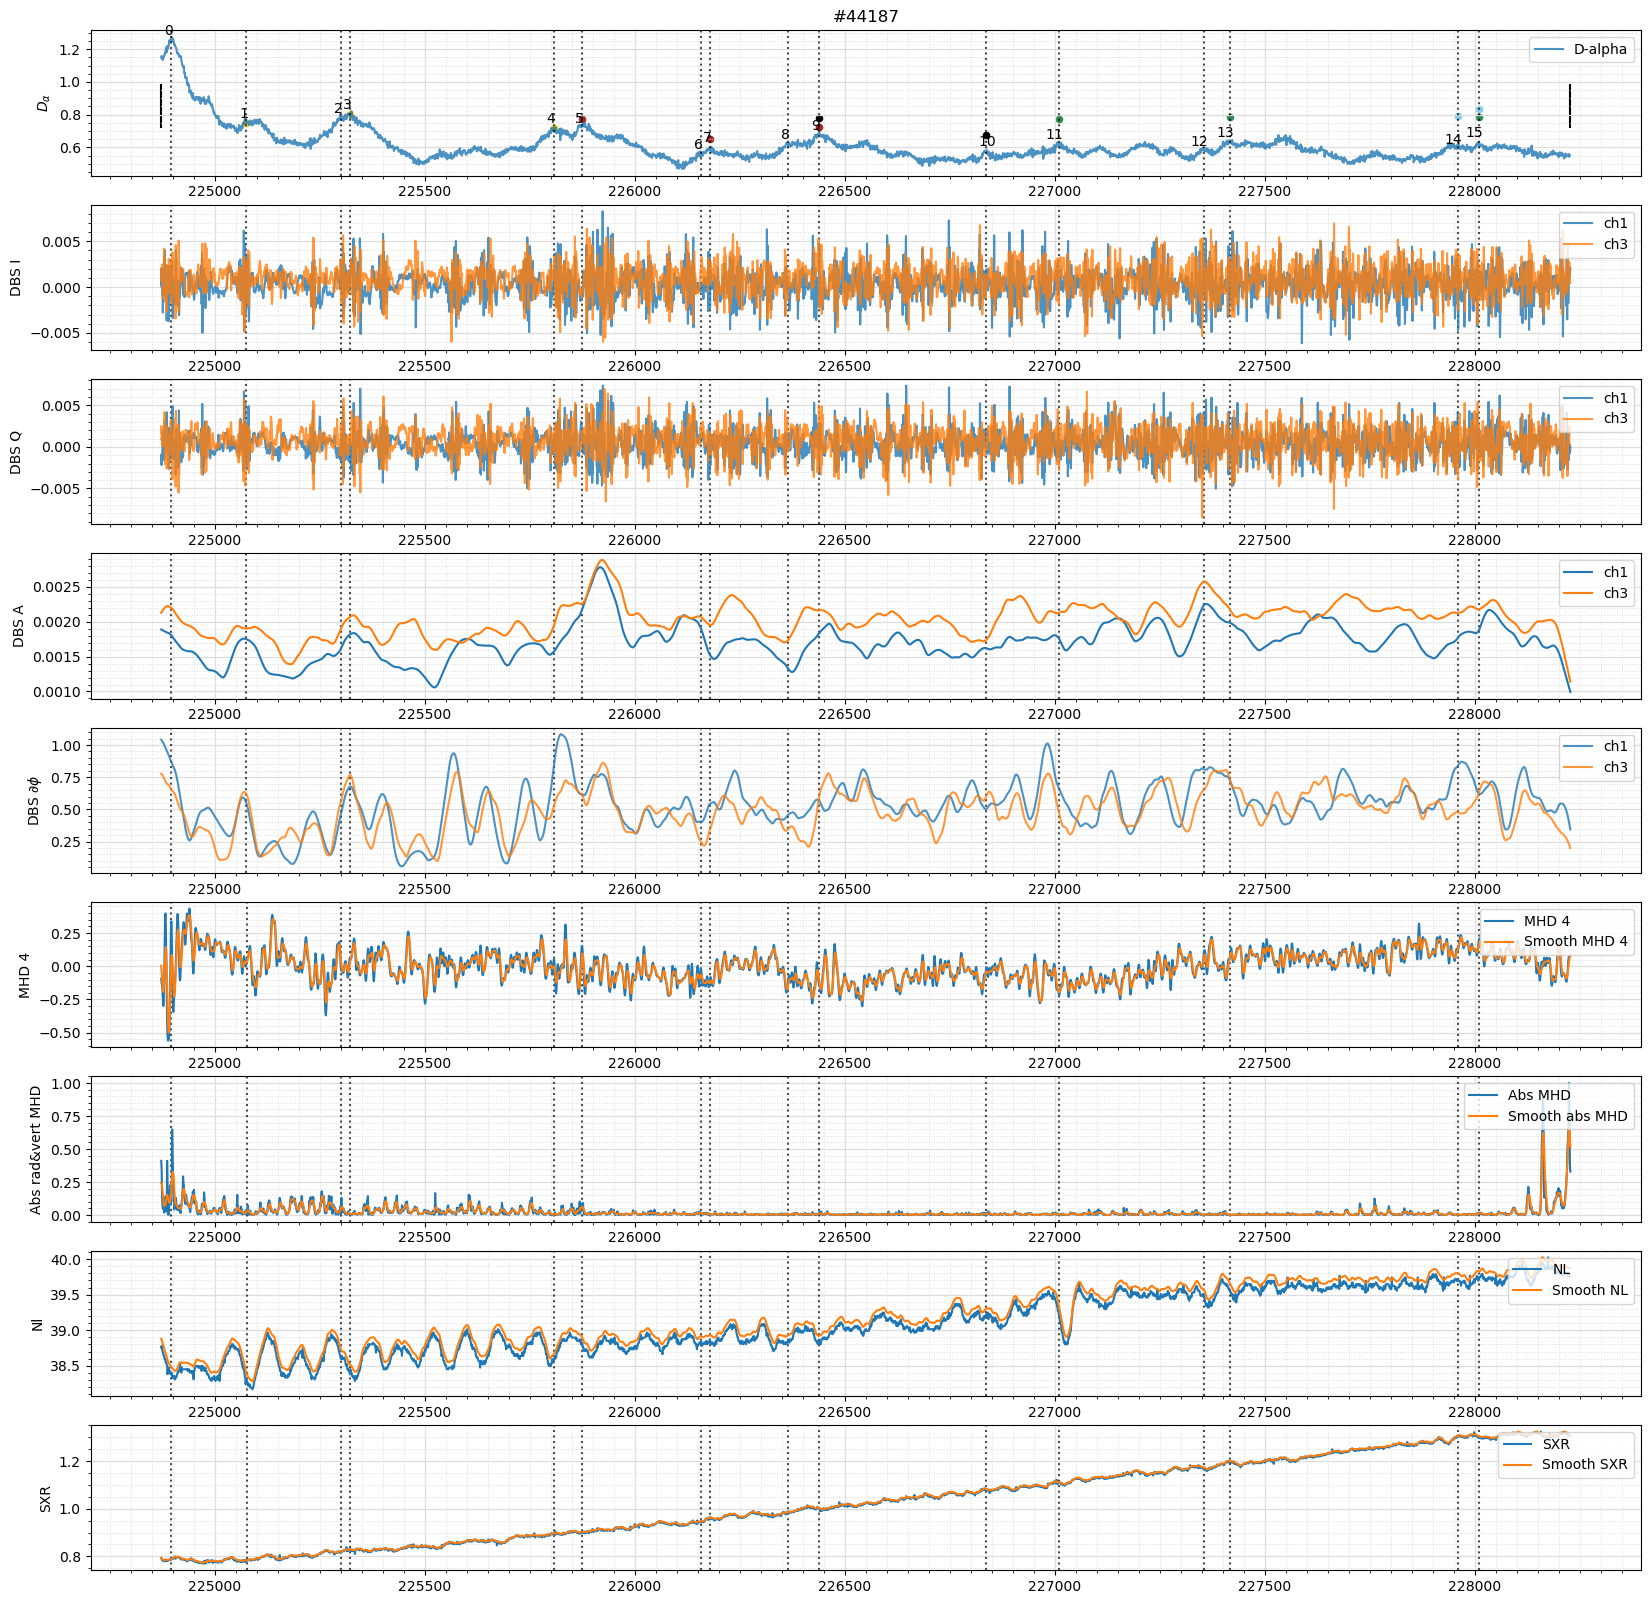

KeyboardInterrupt: Interrupted by user

In [46]:
start_ind = 0  # 0 | 44184 - 9; 44171 - 6; 44172 - 8; 44187 - 6 (4 - syncELM)
bottom_width = 2000

for ind in range(start_ind, res_slices_edges.shape[0]):
    l_edge, r_edge = res_slices_edges[ind]
    plot_l_edge, plot_r_edge = l_edge, r_edge

    if plot_r_edge - plot_l_edge < bottom_width:
        increasing_d = bottom_width  - (plot_r_edge - plot_l_edge)
        plot_l_edge -= increasing_d
        plot_r_edge += increasing_d

    fig, axs = plt.subplots(nrows=9, gridspec_kw={'hspace': 0.2})  # , sharex=True
    
    fig.set_figwidth(20)
    fig.set_figheight(20)
    
    axs[0].set_title(f"#{F_ID}")
    
    b, a = signal.butter(5, 0.1)
    d_alpha_d2f = signal.filtfilt(b, a, np.diff(d_alpha_f))
    
    axs[0].plot(range(plot_l_edge, plot_r_edge), d_alpha[plot_l_edge:plot_r_edge], label="D-alpha", alpha=0.8, zorder=2)
    
    # axs[0].plot(range(plot_l_edge, plot_r_edge), d_alpha_f[plot_l_edge:plot_r_edge] * 10, label="Filtered D1 (x10)", alpha=0.8)
    # axs[0].plot(range(plot_l_edge, plot_r_edge), d_alpha_d2f[plot_l_edge:plot_r_edge] * 100, label="D2 (x100)", alpha=0.8)
    # axs[0].axhline(d_alpha_f.mean(), color="red", linestyle=':', linewidth=0.8)
    # axs[0].axhline((d_alpha_f.mean() + d_alpha_f.std()) * 10 * coef, color="green", linestyle=':', linewidth=0.8)
    # axs[0].axhline((d_alpha_f.mean() - d_alpha_f.std()) * 10 * coef, color="green", linestyle=':', linewidth=0.8)
    # axs[0].axhline((d_alpha_d2f.mean() + d_alpha_d2f.std()) * 100, color="blue", linestyle=':', linewidth=0.8)
    # axs[0].axhline((d_alpha_d2f.mean() - d_alpha_d2f.std()) * 100, color="blue", linestyle=':', linewidth=0.8)

    
    edges_y = (d_alpha[plot_l_edge] + d_alpha[plot_r_edge]) / 2
    axs[0].scatter([l_edge, r_edge], [edges_y, edges_y], s=1000, color="black", marker="|", zorder=1)  # d_alpha[l_edge], d_alpha[r_edge]

    start_time = time.time()
    coef=1.
    x = get_d1_crosses(d_alpha_f, d_alpha_d2f, l_edge, r_edge, d1_coef=coef)
    print(f"\n------\n------\n\n{ind + 1}/{res_slices_edges.shape[0]} - Slice ({l_edge/1e3}, {r_edge/1e3}) ms - mark: {res_slices_marks[ind]} (1 - dELM, 2 - LCO, 3 - EHO) - {len(x)} peaks - {(time.time() - start_time)*1e3:.3f} ms")
    # axs[0].scatter(x, d_alpha[x], s=20, color="black")

    if len(x) > 1:
        print(f"Start prossecing peaks ...", end=" ")  # 
        start_time = time.time()
        res_groups_peaks = get_groups_from_signal(d_alpha, d_alpha_f, d_alpha_d2f, l_edge, r_edge)
        # print("- logg: ", res_groups_peaks)
        print(f"- Tooks: {(time.time() - start_time)*1e3:.3f} ms")
        for g_i in range(len(res_groups_peaks)):
            points = res_groups_peaks[g_i]
            c = colors[g_i % len(colors)]
            axs[0].scatter(points, d_alpha[points] + g_i * 0.05, s=20, color=c, zorder=0)
            
            m_d = get_time_delta(points) / 1e3
            std_d = 0


            for p_i in range(1, len(points)):
                std_d += (m_d - (points[p_i] - points[p_i - 1]) / 1e3) ** 2
            std_d = (std_d / len(points) / (len(points) - 1)) ** .5
            print(f"{g_i + 1}/{len(res_groups_peaks)} Group of peaks [{np.argwhere(x == points[0])[0, 0]}-{np.argwhere(x == points[-1])[0, 0]}] ({c}) - {len(points)} peaks in group - mean delta: {m_d:.3f} ms - freq: {1/m_d:.3f} +- {std_d/(m_d ** 2):.3f} kHz")
        
        for p_i in range(len(x)):
            num = p_i
            d = 0
            while num > 10:
                num = num // 10
                d += 1
            axs[0].annotate(p_i, (x[p_i] - (25) * (r_edge - l_edge) / 5000 - 15 * d, d_alpha[x[p_i]] + 0.03))
            for ax in axs:
                ax.axvline(x[p_i], linestyle=':', color='k', alpha=0.7)
    elif len(x) == 1:
        axs[0].annotate(0, (x[0] - (25) * (r_edge - l_edge) / 5000 - 15 * d, d_alpha[x[0]] + 0.03))
        axs[0].scatter(x, d_alpha[x], s=20, color="black")
        for ax in axs:
            ax.axvline(x[0], linestyle=':', color='k', alpha=0.7)

    for i in channels[::2]:  # channels[::2]
        time_mask = np.array((dbs_df.t * 1e6 >= plot_l_edge) & (dbs_df.t * 1e6 <= plot_r_edge))
        axs[1].plot(np.linspace(plot_l_edge, plot_r_edge, np.count_nonzero(time_mask)), normalize(dbs_df[f"ch{i}"].to_numpy()[:,np.newaxis], axis=0).ravel()[time_mask], label=f"ch{i}", alpha=0.8)
        axs[2].plot(np.linspace(plot_l_edge, plot_r_edge, np.count_nonzero(time_mask)), normalize(dbs_df[f"ch{i + 1}"].to_numpy()[:,np.newaxis], axis=0).ravel()[time_mask], label=f"ch{i}", alpha=0.8)
        axs[3].plot(np.linspace(plot_l_edge, plot_r_edge, np.count_nonzero(time_mask)), dbs_df[f"ch{i}_A"][time_mask], label=f"ch{i}")  # filt_signal(
        axs[4].plot(np.linspace(plot_l_edge, plot_r_edge, np.count_nonzero(time_mask)), dbs_df[f"ch{i}_dfi"][time_mask], label=f"ch{i}", alpha=0.8)

    axs[-4].plot(range(plot_l_edge, plot_r_edge), df.mhd4[plot_l_edge:plot_r_edge], label="MHD 4")
    axs[-4].plot(range(plot_l_edge, plot_r_edge), smooth_steklov(df.mhd4.to_numpy(), 100)[plot_l_edge:plot_r_edge], label="Smooth MHD 4")

    axs[-3].plot(range(plot_l_edge, plot_r_edge), mhd[plot_l_edge:plot_r_edge], label="Abs MHD")
    axs[-3].plot(range(plot_l_edge, plot_r_edge), smooth_steklov(mhd, 100)[plot_l_edge:plot_r_edge], label="Smooth abs MHD")

    axs[-2].plot(range(plot_l_edge, plot_r_edge), df.nl[plot_l_edge:plot_r_edge], label="NL")
    axs[-2].plot(range(plot_l_edge, plot_r_edge), smooth_steklov(df.nl.to_numpy(), 100)[plot_l_edge:plot_r_edge], label="Smooth NL")

    axs[-1].plot(range(plot_l_edge, plot_r_edge), sxr[plot_l_edge:plot_r_edge], label="SXR")
    axs[-1].plot(range(plot_l_edge, plot_r_edge), smooth_steklov(sxr, 100)[plot_l_edge:plot_r_edge], label="Smooth SXR")

    plot_ylabels = [r"$D_\alpha$", "DBS I", "DBS Q", "DBS A", r"DBS $\partial\phi$", "MHD 4", "Abs rad&vert MHD", "Nl", "SXR"]  # 
    for ax_i, ax in enumerate(axs):
        ax.set_ylabel(plot_ylabels[ax_i])
        ax.grid(which='major', color='#DDDDDD', linewidth=0.9)
        ax.grid(which='minor', color='#DDDDDD', linestyle=':', linewidth=0.7)
        ax.minorticks_on()
        ax.xaxis.set_minor_locator(AutoMinorLocator(10))
        ax.legend(loc='upper right')
    
    plt.show()
    
    mode = input("Input mode [manual (input points) - 0 | auto (input group) - 1 | continue - -1]: ")
    while mode != "" and int(mode) >= 0:
        mode = int(mode)
        if mode == 0:
            points_ind = list(map(int, input("Input point indexes:\n").strip().split()))
            points = x[points_ind]
        else:
            gr_ind = int(input(f"Input group number (from 1 to {len(res_groups_peaks)}): ").strip().split()[0]) - 1
            points = res_groups_peaks[gr_ind]
        
        mark = input("Input mark of the group (string: eho|lco|delm)")

        # mean delta in group
        m_d = get_time_delta(points) / 1e3

        # delta std
        std_d = 0
        for p_i in range(len(points)):
            df_points_arr.append([df.t[points[p_i]], 1 / m_d, mark])
            if p_i > 0:
                std_d += (m_d - (points[p_i] - points[p_i - 1]) / 1e3) ** 2
        std_d = (std_d / len(points) / (len(points) - 1)) ** .5
        
        df_groups_arr.append([points[0] - 50, points[-1] + 50, len(points), 1/m_d, std_d/(m_d ** 2), mark]) 

        print(f"Group stats: n: {len(points)}, fr: ({1/m_d:.3f} +- {std_d/(m_d ** 2):.3f}) kHZ\n------")
        
        mode = input("Input mode [manual (input points) - 0 | auto (input group) - 1 | continue - -1]: ")

In [ ]:
print(f"Shot {F_ID}\n----")
print(f"Samples (total: {len(df_points_arr)}): EHO - {np.count_nonzero(np.array(df_points_arr)[:, 2] == 'eho')}, LCO - {np.count_nonzero(np.array(df_points_arr)[:, 2] == 'lco')}, dELM - {np.count_nonzero(np.array(df_points_arr)[:, 2] == 'delm')}")
print(f"Groups (total: {len(df_groups_arr)}): EHO - {np.count_nonzero(np.array(df_groups_arr)[:, -1] == 'eho')}, LCO - {np.count_nonzero(np.array(df_groups_arr)[:, -1] == 'lco')}, dELM - {np.count_nonzero(np.array(df_groups_arr)[:, -1] == 'delm')}")

In [ ]:
# l_edge, r_edge, n, fr, fr std
gr_df = pd.DataFrame(sorted(df_groups_arr, key=lambda x: x[0]), columns=["l_edge", "r_edge", "n", "fr", "fr_std", "mark"])
p_df = pd.DataFrame(sorted(df_points_arr, key=lambda x: x[0]), columns=["timepoint, ms", "fr, kHz", "mark"])

gr_df.to_csv(f"data/df/stats/groups/{F_ID}_groups_stats.csv", index=False)
p_df.to_csv(f"data/df/stats/samples/{F_ID}_points_dataset.csv", index=False)

---
---

In [29]:
res_slices_df = pd.read_csv(proj_path + f"/data/df/stats/{F_ID}_slices_stats.csv")
res_slices_edges = res_slices_df.to_numpy()[:, :2].astype(np.int64)
res_slices_marks = res_slices_df.to_numpy()[:, -1].astype(np.int64)
# print(len(res_slices_edges))
res_slices_df.head()

,l_edge,r_edge,n,fr,fr_std,mark
0,164202,165528,5,3.262643,0.114376,2
1,166611,167338,3,3.189793,0.179170,2
2,167588,168519,3,2.406739,0.021738,2
3,168786,170025,6,4.389816,0.267177,2
4,168786,170268,7,4.341534,0.224523,2


---
---

In [ ]:
slices_df = pd.read_csv(proj_path + f"/data/df/marks/{F_ID}_marks.csv")
slices_edges = slices_df.to_numpy()[:, :2]
slices_marks = slices_df.to_numpy()[:, 2]

---
---